I approached the problem in the following steps;
- Exploratory Data Analysis, creating rules based model.
- Applying Logistic Regression
- Applying Random Forest model


### 1. Exploratory Data Analysis

In [122]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Importing the dataset
data = pd.read_csv("C:/Users/Z005608/Downloads/data_test.csv")

In [7]:
# checking the dataframe
data.head(5)

,created,device_name,device_os_version,country,city_id,lat,lng,real_destination_lat,real_destination_lng,user_id,...,distance,ride_distance,price,ride_price,price_review_status,price_review_reason,is_successful_payment,name,card_bin,failed_attempts
0,2016-01-23 23:10:07,motorolaXT1562,motorola6.0.1,ee,2.0,58.378220,26.710402,58.363243,26.737696,218,...,773,3017,4.5000,4.5000,ok,NaN,1,**** 0810,NaN,0
1,2016-05-04 06:01:32,iPhone6,iOS10.3.3,ee,1.0,59.424130,24.646359,59.397548,24.660957,266,...,43,4241,4.4000,4.4000,ok,NaN,1,**** 9115,NaN,0
2,2016-08-27 16:42:22,HTCHTC 10,HTC7.0,ee,1.0,59.413508,24.743706,59.448500,24.804887,551,...,1654,6347,7.2000,7.2000,ok,NaN,1,**** 0634,516903.0,0
3,2016-10-25 07:14:27,iPhone6S,iOS10.3.2,ee,1.0,59.419938,24.744795,59.431686,24.720801,798,...,883,2638,3.1000,3.1000,ok,NaN,1,**** 8730,541747.0,0
4,2016-09-09 12:46:47,"iPhone5,2",iOS9.3.4,ee,1.0,59.471328,24.890557,59.427836,24.774460,944,...,1109,10288,9.0999,9.0999,ok,NaN,1,**** 3503,NaN,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304053 entries, 0 to 304052
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   created                304053 non-null  object 
 1   device_name            304053 non-null  object 
 2   device_os_version      304053 non-null  object 
 3   country                304052 non-null  object 
 4   city_id                303734 non-null  float64
 5   lat                    304053 non-null  float64
 6   lng                    304053 non-null  float64
 7   real_destination_lat   304026 non-null  float64
 8   real_destination_lng   304026 non-null  float64
 9   user_id                304053 non-null  int64  
 10  order_id               304053 non-null  int64  
 11  order_try_id           304053 non-null  int64  
 12  distance               304053 non-null  int64  
 13  ride_distance          304053 non-null  int64  
 14  price                  304053 non-nu

In [8]:
#changing timestamp type to correct type.
data["created"]=pd.to_datetime(data["created"])
data.isna().sum()
#there seem to be some null values in some columns. 

created                       0
device_name                   0
device_os_version             0
country                       1
city_id                     319
lat                           0
lng                           0
real_destination_lat         27
real_destination_lng         27
user_id                       0
order_id                      0
order_try_id                  0
distance                      0
ride_distance                 0
price                         0
ride_price                    0
price_review_status           0
price_review_reason      302945
is_successful_payment         0
name                          0
card_bin                   6578
failed_attempts               0
dtype: int64

In [9]:
#country, city_id, real_destination_lat, real_destination_lng cannot be null since these informations are necessary.
# Assuming that there could be some online payment way where card bin is not required, ignoring null values in this column.
#Therefore, dropping these rows for data cleaning purposes.
#Also, dropping rows where "price_review_status" is not "ok"
data = data.dropna(subset=(['country', 'city_id','real_destination_lat', 'real_destination_lng']))
data = data[data.price_review_status != 'ok']

In [10]:
# Creating new columns from timestamp information
data['day_of_week'] = data['created'].dt.day_name()
data['hour'] = data['created'].dt.hour

1    224790
0     78917
Name: is_successful_payment, dtype: int64

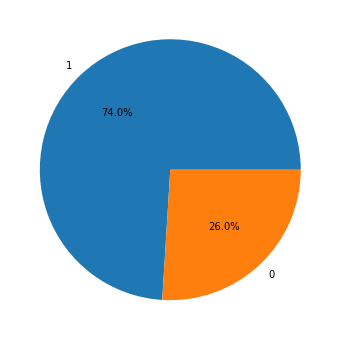

In [11]:
# Checking the ratio of failed payments
a = data['is_successful_payment'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(14,6))
a.axes.get_yaxis().set_visible(False)
data.is_successful_payment.value_counts()

1    224790
0     17036
Name: is_successful_payment, dtype: int64

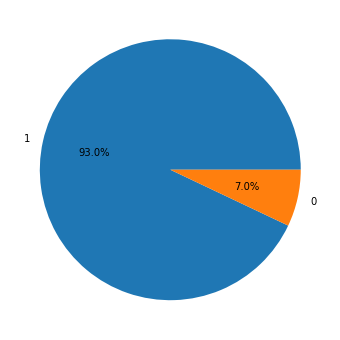

In [12]:
# filtering out where "price after discount" is zero. 
# Since there is no actual price, it should not be considered as fraud (false alarm)
data =data[data.price > 0 ]
a = data['is_successful_payment'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(14,6))
a.axes.get_yaxis().set_visible(False)
data.is_successful_payment.value_counts()

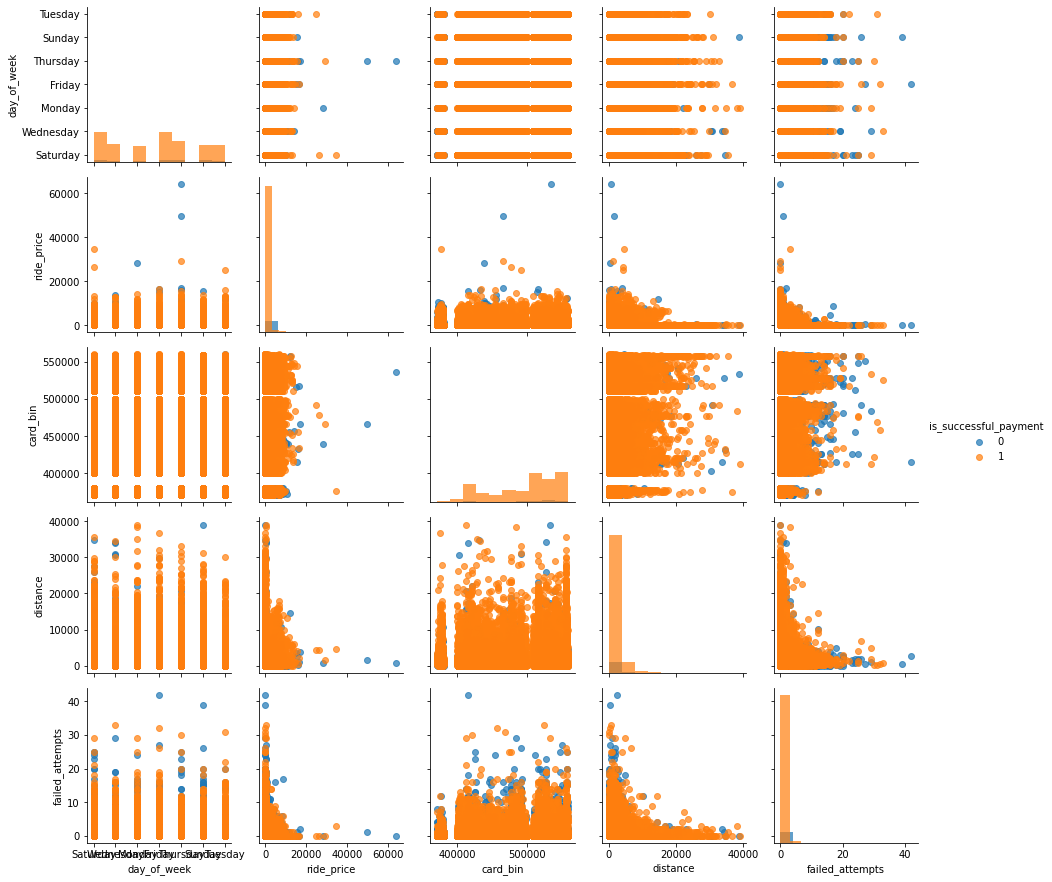

In [13]:
# checking the fraudelent payments across the variables
first_payment = sns.PairGrid(data, vars = ['day_of_week', 'ride_price', 'card_bin', 'distance', 'failed_attempts'], hue = 'is_successful_payment')
first_payment.map_diag(plt.hist, alpha = 0.7)
first_payment.map_offdiag(plt.scatter, alpha = 0.7)
first_payment.add_legend()

From the pairgrid above we can see there are some outliers of fraudelent payments for different selected vairables.
Next, I will explore more some of these variables in detail.

In [14]:
#creating subset dataframes for fraudelent and non fraudelent payments
fraud = data[data['is_successful_payment']==0]
not_fraud = data[data['is_successful_payment']==1]

In [15]:
#filtering card bins with successful payment history out from fraudelent sub dataset 
card_list = fraud['card_bin'].isin(not_fraud['card_bin'])
black_list = fraud.drop(fraud[card_list].index)
black_list.groupby('card_bin')['is_successful_payment'].value_counts().sort_values(ascending=False)
# There are some card bins which only have failed payment history. 

card_bin  is_successful_payment
518759.0  0                        191
522772.0  0                        163
548822.0  0                        116
521628.0  0                         40
533935.0  0                         15
                                  ... 
379812.0  0                          1
379808.0  0                          1
379783.0  0                          1
379778.0  0                          1
559396.0  0                          1
Name: is_successful_payment, Length: 611, dtype: int64

In [16]:
black_list.groupby(['card_bin','country'])['is_successful_payment'].value_counts().loc[lambda x : x>10] 


card_bin  country  is_successful_payment
518759.0  mx       0                        191
521628.0  mx       0                         40
522772.0  mx       0                        163
533935.0  lv       0                         15
548822.0  mx       0                        116
553890.0  mx       0                         12
Name: is_successful_payment, dtype: int64

From above numbers one can interprete that certain card bins are only used for fraud. Also considering country information some control could be set for these card bins. 
For specific country list, these card bins with high count values (lets say greater than 10) could be blacklisted or subjected to extra verification
As an example, if country = 'MX' & card_bin in (black_listed card bins) then "fraudelent" else "non_fraudelent".

<AxesSubplot:ylabel='day_of_week'>

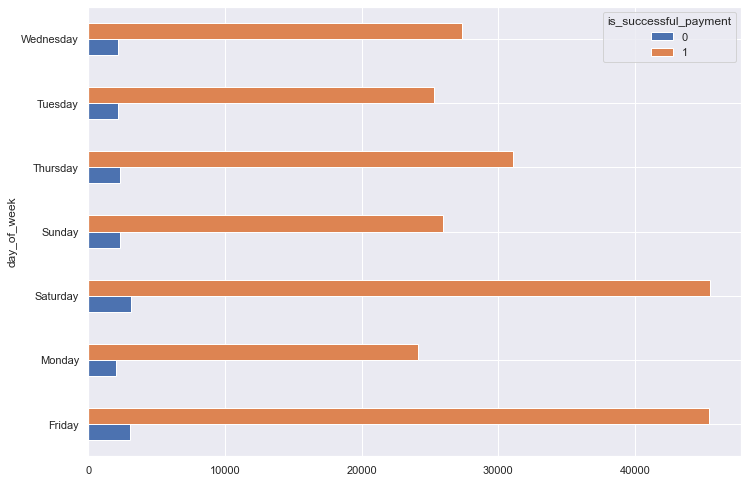

In [18]:
# Checking whether there are some days of week where unusual fraudelent payments happened
sns.set(rc={'figure.figsize':(11.7,8.27)})
data.groupby('day_of_week')['is_successful_payment'].value_counts().unstack().plot.barh()

<AxesSubplot:xlabel='hour'>

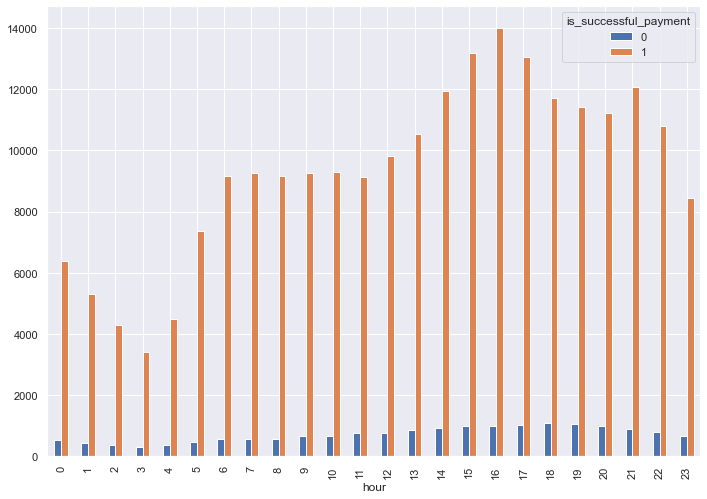

In [19]:
# Checking whether there are some hours of day where unusual fraudelent payments happened
sns.set(rc={'figure.figsize':(11.7,8.27)})
data.groupby('hour')['is_successful_payment'].value_counts().unstack().plot.bar()

Distribution of successfull and failed payments by days of week and hour of the day follow quite similar pattern. Therefore, it is difficult to set up some rule based on timestamp in this specific case. However, advanced statistical techniques (Machine learning) might still find timestamp to be important to identify fraudelent payments.

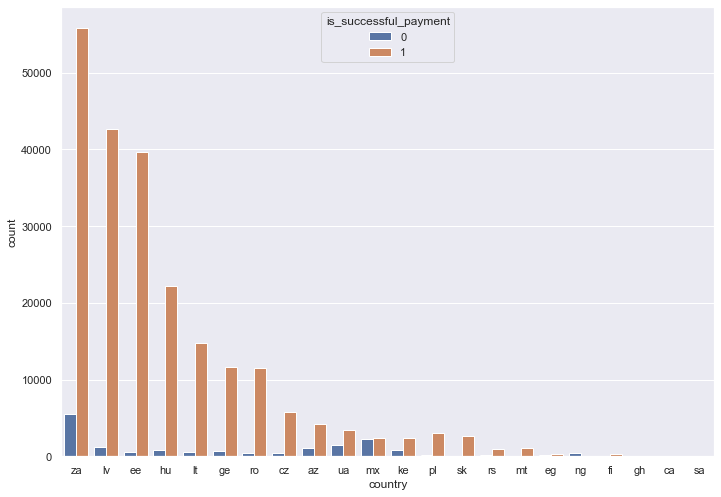

In [20]:
# Checking proportion of failure payments by country
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax=sns.countplot(x="country",data=data,order=data.country.value_counts().index, hue="is_successful_payment")


We can see that for some countries fraudelent payment ratio is quite high, e.g MX, UA, NG. Those countries could be highlighted as high risk countries. Morover, in terms actual numbers there are countries where fraudelent payment count is too high such as ZA. These countries also could be put in high risk category above. 

In [21]:
# There could be specific os_versions used for fraud. 
# Filtering os_versions where percentage of failed payments is greater than 40% and total count greater than 200
c = data.groupby('device_os_version')['is_successful_payment'].value_counts(dropna=False)
p = data.groupby('device_os_version')['is_successful_payment'].value_counts(dropna=False, normalize=True)
cp = pd.concat([c,p], axis=1, keys=['counts', 'per']).reset_index()
cp[(cp['is_successful_payment'] == 0) & (cp['per'] > 0.3) & (cp['counts'] > 30)]

,device_os_version,is_successful_payment,counts,per
466,Infinix6.0,0,63,0.388889
559,LENOVO5.1,0,162,0.424084
915,Samsung4.2.2,0,59,0.967213
1016,TECNO5.1,0,36,0.562500
1019,TECNO6.0,0,50,0.324675
1205,ZTE5.1,0,34,0.303571


Above table simply shows us risky device_os_versions, meaning that ratio of these os_versions for fraudelent payments is higher than 40% of total payments. 
As like card_bins, there could be black listed device_os_versions to control fraudelent payments.

In [22]:
# checking is_successful_payment for distance by creating bins.
dist =data.groupby('is_successful_payment')['ride_distance'].value_counts(bins = [0, 5000, 10000, 20000, 100000, 10000000])
dist

is_successful_payment  ride_distance         
0                      (10000.0, 20000.0]         5119
                       (20000.0, 100000.0]        4348
                       (5000.0, 10000.0]          3851
                       (-0.001, 5000.0]           3500
                       (100000.0, 10000000.0]      218
1                      (-0.001, 5000.0]          75965
                       (5000.0, 10000.0]         73848
                       (10000.0, 20000.0]        54249
                       (20000.0, 100000.0]       20675
                       (100000.0, 10000000.0]       53
Name: ride_distance, dtype: int64

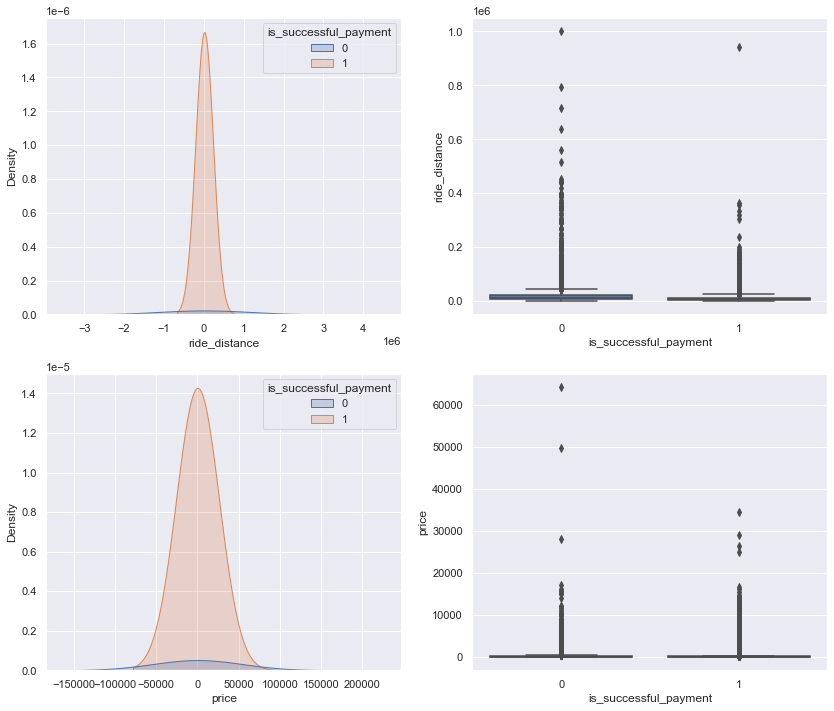

In [37]:
# plotting Kernel density and Box plot for distance and price variables.
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols= 2, figsize=(14, 12))
sns.kdeplot(data=data, x='ride_distance', hue='is_successful_payment', fill= True, bw_adjust = 300,  ax=ax1)
sns.kdeplot(data=data, x='price', hue='is_successful_payment', fill = True, bw_adjust = 300,  ax=ax3)
sns.boxplot(data=data, y='ride_distance', x='is_successful_payment', ax=ax2)
sns.boxplot(data=data, y='price', x='is_successful_payment', ax=ax4)
plt.show()

Kernel density plot is skewed to left for both distance and price variables, meaning that majority of transactions made for short distance and low price. They follow similar trend for fraudelent and non fraudelent payments.
But, Boxplot could tell us something. We can interprete from boxplot for distance that there are many payments above certain point where almost all of them are fraudelent. Therefore, some threshold could be set for distance.

Since currency for price is not defined, I will not consider interpretation for this variable.

Above I did Exploratory data analysis and found some insightful information to reduce fraudelent payments.

Developments proposed:
   - New rules could be introduced based on card_bin, country, distance and device_os_version variables.
   - As mentioned above high risk list could be created for bespoke variables.
-  For instance;

        IF card_bin in black_listed_bins 
            AND(OR) country in high_risk_country 
            AND(OR) distance > threshold 
            AND(OR) device_os_version in black_list
        
        THEN "FRAUDELENT" 
        ELSE "NORMAL"

               
As a second approach, common risk score could be assigned based on attributes.

For example;
  - If payment is from high_risk country then risk score increases +3.
  - If payment is done by black listed card_bins then risk score increases +3  
  - If distance is > threshold then risk score increases +2
  - if payment is done by balck listed os_versions then risk score increases +2 
    
Eventually, 
   - If risk score reaches 9-10, then payment is high risk fraud. Should be blocked.
   - If risk score is between 6-8 then moderate risk, request extra verification
   - If risk score is below 6 then allow payment 


### Feature Engineering

In [38]:
# Undersampling
# Since there is 7% of fraudelent payments, to balance the dataset undersampling will be done.
len(fraud) 

17036

In [39]:
not_fraud_sample = not_fraud.sample(n=17036)

In [40]:
new_data = pd.concat([not_fraud_sample, fraud], axis=0)
new_data['is_successful_payment'].value_counts()

1    17036
0    17036
Name: is_successful_payment, dtype: int64

In [41]:
new_data.groupby('is_successful_payment').mean()

,city_id,lat,lng,real_destination_lat,real_destination_lng,user_id,order_id,order_try_id,distance,ride_distance,price,ride_price,card_bin,failed_attempts,hour
is_successful_payment,,,,,,,,,,,,,,,
0,145.28205,16.621903,11.466885,16.624920,11.470073,1.207012e+06,1.448722e+07,1.489043e+07,1666.939775,17994.788037,382.394759,404.403241,487462.923530,0.834468,13.395163
1,70.54150,31.916981,24.462165,31.916444,24.464056,1.033268e+06,1.413077e+07,1.450766e+07,1607.719653,9354.378551,297.858336,309.539540,495291.383978,0.316917,13.124618


In [105]:
## creating new sub data with selected features only. 
## city_id, price, distance, failed attempts are selected
## new target variable, "is_fraud", created by simply reversing the "is_successful_payment" column to ease the interpretation of ML models
sub_data = new_data[['is_successful_payment', 'city_id', 'lat', 'lng', 'real_destination_lat', 'real_destination_lng','distance', 'ride_distance', 'price',  'failed_attempts']]
sub_data['is_fraud'] = sub_data['is_successful_payment'].map({0:1,1:0})
sub_data = sub_data.drop('is_successful_payment', axis=1)
sub_data.head()

,city_id,lat,lng,real_destination_lat,real_destination_lng,distance,ride_distance,price,failed_attempts,is_fraud
278369,54.0,-25.732202,28.137219,-25.747458,28.194755,3561,7438,70.0,0,0
28096,260.0,44.821401,20.461780,44.813877,20.429186,594,4119,394.0,0,0
78530,54.0,-26.001190,28.012412,-25.979520,28.117562,1722,16015,20.0,0,0
273188,7.0,47.500298,19.068693,47.485371,19.082484,397,2901,1320.0,0,0
255007,1.0,59.432021,24.758427,59.435724,24.749547,779,1433,2.8,0,0


In [106]:
# converting date type of city id into category
sub_data['city_id'] = sub_data['city_id'].astype('category')

sub_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34072 entries, 278369 to 304039
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   city_id               34072 non-null  category
 1   lat                   34072 non-null  float64 
 2   lng                   34072 non-null  float64 
 3   real_destination_lat  34072 non-null  float64 
 4   real_destination_lng  34072 non-null  float64 
 5   distance              34072 non-null  int64   
 6   ride_distance         34072 non-null  int64   
 7   price                 34072 non-null  float64 
 8   failed_attempts       34072 non-null  int64   
 9   is_fraud              34072 non-null  int64   
dtypes: category(1), float64(5), int64(4)
memory usage: 2.6 MB


In [52]:
# importing library to split the data into train and test
from sklearn.model_selection import train_test_split

In [107]:
# splitting data into target (Y) and predicting (X) variables
Y = sub_data['is_fraud']
features = sub_data.drop('is_fraud', axis=1)
X = features

In [54]:
Y.head()

278369    0
28096     0
78530     0
273188    0
255007    0
Name: is_fraud, dtype: int64

In [108]:
#create X_train, X_test, Y_train, Y_test
# using test_size of 20%

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size = 0.80, test_size = 0.20, random_state = 2)

### 2. Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression()

In [109]:
#Training model with Training data
model_lr.fit(X_train, Y_train)

LogisticRegression()

In [110]:
## getting the coefficients of Logistic regression to see how each feature is important for target variable.
pd.DataFrame(zip(X_train.columns, np.transpose(model_lr.coef_.round(6))), columns=['features', 'coef']) 

,features,coef
0,city_id,[0.003601]
1,lat,[-0.006481]
2,lng,[-0.005227]
3,real_destination_lat,[-0.006075]
4,real_destination_lng,[-0.005477]
5,distance,[-3e-05]
6,ride_distance,[2.1e-05]
7,price,[5.6e-05]
8,failed_attempts,[0.041598]


In [94]:
model_lr_pred = model_lr.predict(X_test)

In [60]:
#importing the methods
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_recall_curve, average_precision_score, roc_auc_score

In [111]:
# checking accuracy of model
print(classification_report(Y_test, model_lr_pred))

              precision    recall  f1-score   support

           0       0.67      0.60      0.63      3416
           1       0.64      0.70      0.67      3399

    accuracy                           0.65      6815
   macro avg       0.65      0.65      0.65      6815
weighted avg       0.65      0.65      0.65      6815



In [112]:
# confusion matrix to check the performance of model
pd.DataFrame(confusion_matrix(Y_test, model_lr_pred), 
             columns=['Predicted Negative(0) ', 'Predicted Positive(1)'], 
             index=['Actually Negative(0)', 'Actually Positive(1)'])

,Predicted Negative(0),Predicted Positive(1)
Actually Negative(0),2055,1361
Actually Positive(1),1009,2390


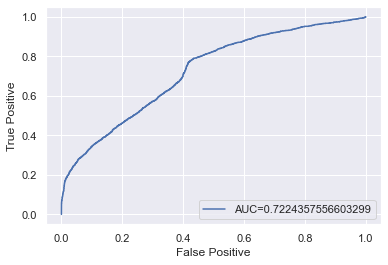

In [113]:
# getting AUC and plotting ROC curve
lr_pred_proba = model_lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  lr_pred_proba)
auc = metrics.roc_auc_score(Y_test, lr_pred_proba)


plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive')
plt.xlabel('False Positive')
plt.legend(loc=4)
plt.show()

Logistic regression is classical approach for classification problems. Above I tried to use it in order to find fraudelent payments by training the model. Model accuracy is 65% and AUC is 72%. Performance is a bit low, however, it could be improved by adding more features into the model. 

From the coefficients of the model, we see that price, ride_distance and failed attempts are positively related to fraud however, distance is negatively related. When price is high, ride_distance is far, more failed attempts, and distance is short then payment is likely fraudelent. 

I added coordinates into the model just to check if model will improve since there are very few features otherwise. Adding coordinates actually decreased the model performance, however, I keep it in dataset for the next ML model. 

### 3. Random Forest

In [114]:
from sklearn.ensemble import RandomForestClassifier
# Define the model as the random forest
model_rf = RandomForestClassifier(random_state=3, n_estimators=20)

In [115]:
model_rf.fit(X_train,Y_train)

RandomForestClassifier(n_estimators=20, random_state=3)

In [116]:
model_rf_pred = model_rf.predict(X_test)


In [67]:
#importing the methods
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_recall_curve, average_precision_score, roc_auc_score

In [117]:
# Print classification report using predictions
print(classification_report(Y_test, model_rf_pred))

              precision    recall  f1-score   support

           0       0.69      0.77      0.73      3416
           1       0.74      0.64      0.69      3399

    accuracy                           0.71      6815
   macro avg       0.71      0.71      0.71      6815
weighted avg       0.71      0.71      0.71      6815



In [118]:
# Print confusion matrix using predictions
pd.DataFrame(confusion_matrix(Y_test, model_rf_pred), 
             columns=['Predicted Fraud(1) ', 'Predicted Non_Fraud(0)'], 
             index=['Actually Fraud(1)', 'Actually Non_Fraud(0)'])

,Predicted Fraud(1),Predicted Non_Fraud(0)
Actually Fraud(1),2635,781
Actually Non_Fraud(0),1209,2190


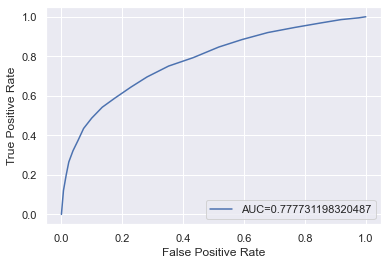

In [119]:
#define metrics
rf_pred_proba = model_rf.predict_proba(X_test)[::,1]
fpr_rf, tpr_rf, _rf = metrics.roc_curve(Y_test,  rf_pred_proba)
rf_auc = metrics.roc_auc_score(Y_test, rf_pred_proba)


#create ROC curve
plt.plot(fpr_rf,tpr_rf,label="AUC="+str(rf_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [120]:
#Feature Importance
features = pd.Series(model_rf.feature_importances_, index=X_train.columns)
features.sort_values(ascending=False)

real_destination_lat    0.152660
real_destination_lng    0.142993
lng                     0.136850
lat                     0.127855
ride_distance           0.125522
distance                0.117414
price                   0.112114
city_id                 0.059071
failed_attempts         0.025520
dtype: float64

As a second Machine Lerning model I used Random Forest since it is widely used in Payment Fraud. As mentioned above I kept coordination info to use it in Random Forest model. Adding coordinations improved model performance. Again process followed is same as for Logistic Regression. 

Model accuracy is 71% and AUC is 77% which is better than Logistic Regression. Again model could be improved by hyperparameter tuning. 

From feature importance above, apart from coordinates ride_distance is more important followed by distance and price.